# Loading step
This previous step will get the "x" and "u" values in order to calculate the Comparison Reference Values and Degrees of Equivalence.


In [2]:
import json
import pandas as pd

with open("activity_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)

# PMM
Welcome to the interactive Python notebook for running the Power Moderated Mean method for key comparisons. This notebook provides a user-friendly interface to apply the Power Moderated Mean (PMM) method, facilitating robust statistical analysis and comparison of key data sets.

## Importation of Python modules for math and plot

In [3]:
from numpy import asarray, sum, mean, average, sqrt, zeros, median, arange
from matplotlib.pyplot import subplots, savefig, axhline, rcParams, xlim, ylim, plot, legend, figtext, text, errorbar, figure,tight_layout, xticks
from scipy.optimize import minimize

## PMM code
Below is the Python function for PMM evaluation of the key comparison reference value.

In [4]:
def PMM(x,u,*,autoRej=False,k=2.5,conv=1e-4): # PMM calculation
    """This function calculates the Power-Modered Mean (PMM) on a data sample.
    
    References: 
        [Accred Qual Assur (2008)13:83-89, Metrologia 52(2015)S200]
        https://link.springer.com/article/10.1007/s00769-007-0330-1
        https://iopscience.iop.org/article/10.1088/0026-1394/52/3/S200/pdf
    
    This method is applied to calculate de Key Comparison Reference Value (KCRV)
    related to international inter-laboratory comparisons of the CIPM/CCRI(II). 
    It was validated from PMM v1.xlsm provided by S. Pommé [email of the 14 Jan 2020]
    
    :param x: Sample of values
    :type x: array of floats
    :param u: Sample of standard uncertainties related to the values
    :type u: array of floats
    :param r: (Optional) Set if the auto-rejection capability is activated or not (False by default)
    :type tau: bool 
    :param k: (Optional) Threshold (see as quantiles of a Normal density) of the frequentist test (default value = 2.5)
    :type k: float 
    :param conv: (Optional) Convergence paramater (set ny default equal to 1e-4)
    :type conv: float    
    :param x_ref: Estimation of the reference value
    :type x_ref: float
    :param ux_ref: Estimation of uncertainty of the reference value
    :type ux_ref: float
    :param w: Weights associated to each data point
    :type w: array of floats
    :param alpha: Value of the power paramater alpha 
    :type alpha: float
    :param birge0: Value of the Birge ratio (before adjustment) 
    :type birge0: float
    :param s: Estimation of the inter-laboratory standard deviation
    :type s: float
    :param rej: Index of the rejected points
    :type rej: list of int  

    :return y: x_ref, ux_ref, w, alpha, birge0, s, rej
    :rtype y: tuple
    """
   
    def BirgeAdjust(x,u,s0,n,*,c=1e-4):
        """This function minimize the cost function (Birge-1).
        
        :param b: Initial Birge ratio
        :type b: floats
        :param x: Sample of values
        :type x: array of floats
        :param u: Sample of standard uncertainties related to the values
        :type u: array of floats
        :param s: Initial inter-laboratory standard deviation
        :type s: floats
        :param n: Length of the data set
        :type n: int
        :param c: (Optional) Convergence paramater (set ny default equal to 1e-4)
        :type c: float
       
        :return s: Estimation of the inter-laboratory standard deviation
        :rtype s: float    
        """
        def birge_ratio(s, x, u, n):
            weights = 1 / (u**2 + s**2)
            x_mp = average(x, weights=weights)
            return (1 / (n - 1)) * sum((x - x_mp)**2 / (u**2 + s**2)) - 1
        def objective(s):
            return abs(birge_ratio(s, x, u, n))
        result = minimize(objective, s0, bounds=[(1e-6, None)], tol=c)
        if not result.success:
            raise RuntimeError("Optimization did not converge.")
        s = result.x[0]
        return s

#        while (b-1)>1e-4:       # Make to Birge ratio equal to 1
#            x_mp=average(x,weights=1/(u**2+s**2)) # average weighted by the inverse of the variance
#            b=(1/(n-1))*sum((x-x_mp)**2/((u**2+s**2)))  # Calculation of the Birge ratio
#            if (b-1)>0:
#                s=s+ds      # increase the value of the inter-laboratory standart deviation 
#            else:
#                s=s-ds      # decrease the value of the inter-laboratory standart deviation 
#            if s<0:         # detection of correltation between values
#                break # break the calculation
#        return s

    x=asarray(x)        # format input data
    u=asarray(u)        # format input data
    n=len(x)            # length of the data set
    alpha=2-3/n         # initialization of the power paramater alpha    
    s=0                 # initialization of the inter-laboratory standart deviation 
    ds=mean(u)*conv*0.1 # motion step of the inter-laboratory standart deviation 
    x_mp0=average(x,weights=1/(u**2+s**2)) # initial calculation of average weighted by the inverse of the variance
    birge0=sqrt((1/(n-1))*sum((x-x_mp0)**2/((u**2+s**2))))  # Calculation of initial the Birge ratio
#    s=BirgeAdjust(10,x,u,s,n,c=conv) # estimation of the inter-laboratory standart deviation 
    s=BirgeAdjust(x,u,s,n,c=conv) # estimation of the inter-laboratory standart deviation
    barx=sum(x)/n      # calculation of the unweighted empirical mean
    u2_barx=sum((x-barx)**2/(n*(n-1))) # calculation of the unweighted empirical variance (external variance)
    u2_xmp=1/(sum(1/(u**2+s**2)))  # calculation of the weighted variance (internal variance)
    S=sqrt(n*max(u2_barx,u2_xmp))  # characteristic uncertainty per datum
    u2_xref=1/sum(1/((u**2+s**2)**(alpha/2)*S**(2-alpha))) # variance of the reference value
    ux_ref=sqrt(u2_xref) # standard deviation of the reference value
    w=u2_xref/((u**2+s**2)**(alpha/2)*S**(2-alpha))  # weighing factors
    x_ref=sum(w*x) # reference value
    
    rej=[]  # initial the rejection list
    if autoRej==True: # assess and reject outliers
        e=x-x_ref # euclidian distance from the reference value
        u2e_incl=u2_xref*(w**-1-1) # variance of DE including all value
        # Xf=zeros(n)
        # uf=zeros(n)
        xf=[]   # initial filtered data list
        uf=[]   # initial filtered data related standard deviation
        for i in range(n):
            # if abs(e[i])>k*sqrt(u2e_incl[i]): # frequentist test on data see Pommé C.1 (end)
            if abs(e[i])>k*sqrt((1-2*w[i])*u[i]**2+ux_ref**2): # frequentist test idem as in PomPlot !!!!!!!!!!!!!!!!!!
                rej.append(i) # index of the rejected point
            else: # the data point is kept
                xf.append(x[i])
                uf.append(u[i])
        if rej!=[]:
            xf=asarray(xf)  # format the list to array
            uf=asarray(uf)  # format the list to array
            n2=len(xf) # length of the new data set
            s=0
            alpha=2-3/n2         # recalculation of the power paramater alpha
#            s=BirgeAdjust(10,xf,uf,s,n,c=conv) # estimation of the inter-laboratory standart deviation 
            s=BirgeAdjust(xf,uf,s,n,c=conv) # estimation of the inter-laboratory standart deviation
            barx=sum(xf)/n2      # calculation of the unweighted empirical mean
            u2_barx=sum((xf-barx)**2/(n2*(n2-1))) # calculation of the unweighted empirical variance (external variance)
            u2_xmp=1/(sum(1/(uf**2+s**2)))  # calculation of the weighted variance (internal variance)
            S=sqrt(n2*max(u2_barx,u2_xmp))  # characteristic uncertainty per datum
            u2_xref=1/sum(1/((uf**2+s**2)**(alpha/2)*S**(2-alpha))) # variance of the reference value
            ux_ref=sqrt(u2_xref) # standard deviation of the reference value
            w=u2_xref/((uf**2+s**2)**(alpha/2)*S**(2-alpha))  # weighing factors
            x_ref=sum(w*xf) # reference value
    return x_ref, ux_ref, w, alpha, birge0, s, rej

## DoE code
Below is the Python function to calculate the degrees of equivalence from the PMM key comparison reference value.

In [5]:
def DoE(x,u,x_ref,ux_ref,*,w=[],k=2):
    """This function aims to calculate Degrees of equivalence.
    
    This calculation applicable in the frame of international inter-laboratory comparisons of the CIPM/CCRI(II).
    This calculation is associated with the use of the Power-Modered Mean (PMM) estimation of reference values.
    
    References: 
        [Accred Qual Assur (2008)13:83-89, Metrologia 52(2015)S200]
        https://link.springer.com/article/10.1007/s00769-007-0330-1
        https://iopscience.iop.org/article/10.1088/0026-1394/52/3/S200/pdf
    
    :param x: Sample of values
    :type x: array of floats
    :param u: Sample of standard uncertainties related to the values
    :type u: array of floats
    :param x_ref: Estimation of the reference value
    :type x_ref: float
    :param ux_ref: Estimation of uncertainty of the reference value
    :type ux_ref: float
    
    :param w: (Optional) Weights associated to each data point.
    :type w: array of floats
    :param k: (Optional) Coverage factor (set by default equal to 2)
    :type k: float    
    
    :param d: Estimation of the degrees of equivalence
    :type d: array of floats
    :param ud: Estimation of the uncertainties related to the degrees of equivalence
    :type ud: array of floats    
    :param dr: Estimation of the relative degrees of equivalence
    :type dr: array of floats
    :param udr: Estimation of the uncertainties related to the relative degrees of equivalence
    :type udr: array of floats  
    
    :return y: d, ud, dr, udr
    :rtype y: tuple
    """
    if w==[]: w=zeros(len(x))
    x=asarray(x) # format input data
    u=asarray(u) # format input data
    w=asarray(w) # format input data
    k=2
    d=x-x_ref  # euclidian distance from the reference value
    u2d=(1-2*w)*u**2+ux_ref**2 # variance associated with DE (the weight factor is available)
    ud=k*u2d**0.5     # enlarged standard deviation associated with DoE
    dr=d/x_ref        # relative DoE
    udr=ud/x_ref      # relative u(DoE)
    return d, ud, dr, udr

## Code to plot the DoEs
Below is the Python function to plot the degrees of equivalence obtained from the PMM key comparison reference value.

In [6]:
def plotDoE(x,d,ud,dr,udr,*,unitDoE="MBq",unitrDoE="kBq/MBq",scale=1e3,scaleAx=1.5,coef=1e3):
    """
    This function allows to display and save the degrees of equivalence produced during international inter-laboratory comparisons of the CIPM/CCRI(II).
    
    The function has the particularty to display both relative and absolute degrees of equivalence.
    The figure is recorded in the folder of the radionuclide name such as rad.png.
    The function return the DoEs data chronologically sorted.
    
    :param x: List of the laboratory names
    :type x: list of string
    :param t: Years of submissions
    :type t: string
    :param d: Estimation of the degrees of equivalence
    :type d: array of floats
    :param ud: Estimation of the uncertainties related to the degrees of equivalence
    :type ud: array of floats    
    :param dr: Estimation of the relative degrees of equivalence
    :type dr: array of floats
    :param udr: Estimation of the uncertainties related to the relative degrees of equivalence
    :type udr: array of floats   
    :param rad: Name of the radionuclide (eg. Sr-85)
    :type rad: string
    :param year: Year of the comparison
    :type year: string
    :param unitDoE: (Optional) Unit of degrees of equivalence (kBq or MBq) (By default "MBq")
    :type unitDoE: string
    :param unitrDoE: (Optional) Unit of relative degrees of equivalence (kBq or MBq) (By default "kBq/MBq")
    :type unitrDoE: string
    :param scale: (Optional) Scale of the relative degrees of equivalence (By default 1e3)
    :type scale: float
    :param scaleAx: (Optional) Scale of y-axis accordingly to the min max values (By default 1.5)
    :type scaleAx: float
    
    
    :param x: sorted laboratory names.
    :type x: list of strings
    :param d: sorted degrees of equivalence.
    :type d: list of floats
    :param ud: sorted uncertainties of DoEs.
    :type ud: list of floats
    :param dr: sorted relative degrees of equivalence.
    :type dr: list of floats
    :param udr: sorted uncertainties of relative DoEs.
    :type udr: list of floats
    
    :return: DoEs data chronologically sorted: x,d,ud,dr,udr
    :rtype: tuple of lists
    
    """
    k=1       
    fig, ax = subplots() # create of subplot object
    ax2 = ax.twinx() # define a twin-axis
    # define the title
    ax.set_title("Degrees of equivalence for equivalent activity", fontsize=12)
    ax.errorbar(x,d,yerr=ud, fmt='or') # plot the absolute DoEs
    ax.set_ylabel(r'$[D_{i}]$ /'+unitDoE, fontsize=12)
    ax2.errorbar(x,scale*asarray(dr),yerr=scale*asarray(udr), fmt='or', capsize=3, ecolor='r') # plot the relative DoEs
    ax2.set_ylabel(r'$[D_{i}/x_{R}]$ / ('+unitrDoE+')', fontsize=12) 
    # ax.tick_params("x",labelrotation=45, labelbottom=True, bottom=True,labeltop=False) # write NMI name on the x-axis
    # ax2.tick_params("x",labelrotation=45, labelbottom=True, bottom=True,labeltop=False)
    ax.tick_params("x",labelrotation=90, labelbottom=True, bottom=True,labeltop=False) # write NMI name on the x-axis
    ax2.tick_params("x",labelrotation=90, labelbottom=True, bottom=True,labeltop=False)
    axhline(c='k',lw=1)
    # adjust the twin y-axis
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(scaleAx*ymin,scaleAx*ymax)
    ymin, ymax = ax2.get_ylim()
    ax2.set_ylim(scaleAx*ymin,scaleAx*ymax)

## Code PomPlot
Below is the Python function to plot the PomPlot, an alternative representation of key comparison results.

In [7]:
def pomplot(q,d,ud,*,xm=-8,xM=8,ym=5,yM=0,Tpe="KCRV"):    
    """
    This function allows to display the POMPLOT of a inter-laboratory comparison.
    
    It proposes a visualization facilitating the analysis inter-laboratory comparison data.
    The POMPLOT tool is used by the CIPM/CCRI(II).
    The figure is recorded in the folder of the radionuclide name such as rad.png. 
    
    Reference:
    Spasova, Y., Pommé, S. & Wätjen, U. Visualisation of interlaboratory comparison results in PomPlots. Accred Qual Assur 12, 623–627 (2007). https://doi.org/10.1007/s00769-007-0319-9
    
    :param q: Name of the laboratory
    :type q: list of strings    
    :param d: Estimation of the degrees of equivalence
    :type d: array of floats
    :param ud: Estimation of the uncertainties related to the degrees of equivalence
    :type ud: array of floats    
    :param rad: Name of the radionuclide (eg. Sr-85)
    :type rad: string
    :param year: Year of the comparison
    :type year: string
    :param xm: (Optional) Minimum x-axis value of the plot frame (Default -8)
    :type xm: float
    :param xM: (Optional) Minimum x-axis value of the plot frame (Default 8)
    :type xM: float
    :param ym: (Optional) Minimum y-axis value of the plot frame (Default 5)
    :type ym: float
    :param yM: (Optional) Minimum y-axis value of the plot frame (Default 0)
    :type yM: float
    :param Tpe: (Optional) Type of Pomplot. for KCRV or for DoE (Default KCRV)
    
    """
    d=asarray(d)
    # ud=asarray(ud)*0.5  # test correction 24/06 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    ud=asarray(ud)
    MAD=median(abs(d)) # median of absolute value of degrees of equivalence
    x=d/MAD            # x-coordinates
    y=ud/MAD           # y-coordinates
    # set the location of the axis
    rcParams['xtick.bottom'] = rcParams['xtick.labelbottom'] = False
    rcParams['xtick.top'] = rcParams['xtick.labeltop'] = True
    fig, ax = subplots() # create of subplot object
    ax.plot(x,y,'ok')
    # define the frame
    ylim(1.1*max(y),0)
    xlim(1.1*min(x),1.1*max(x))
    # print axes title
    ax.set_title(r'$D_{i}$/med($D$)', fontsize=14)
    ax.set_ylabel(r'$u(D_{i})$/med($D$)', fontsize=14)
    # draw the lignes
    x0=arange(-9,9,1)
    y0=arange(-9,9,1)
    plot(x0,y0,'-g',label=r'$\zeta=1$')
    plot(x0,-y0,'-g')
    plot(x0,y0/2,'-b',label=r'$\zeta=2$')
    plot(x0,-y0/2,'-b')
    plot(x0,y0/3,'-r',label=r'$\zeta=3$')
    plot(x0,-y0/3,'-r')
    for i,g in enumerate(q):
        text(x[i]+0.1,y[i]+0.1,g)
    legend() # display the legend

## Enter your data
`lab` is the list of laboratories
`x` is the measurement values
`u` is the standard uncertainties 

In [8]:
#lab = ["CMI", "IFIN-HH", "IRA",  "JRC", "LNE-LNHB", "NPL", "PTB"]
#x =   [559.4, 550.3,      539.7, 565.2, 560.2,      559.5, 559.0]
#u =   [2.5,   5.1,        2.5,   9.3,   1.7,        1.8,   2.7]

lab = df["lab"].tolist()
x = df["x"].tolist()
u = df["u"].tolist()

## Run PMM without the auto-test (can take time...)
Below the PMM is run skipping the auto-test to reject possible outliers

In [9]:
results=PMM(x,u,autoRej=False)
print(f"KCRV = {results[0]:.7g}")
print(f"u(KCRV) = {results[1]:.7g}")
print(f"Weights = {results[2]}")
print(f"Alpha = {results[3]:.7g}")
print(f"Birge ratio = {results[4]:.7g}")
print(f"Dark uncertainty = {results[5]:.7g}")

KCRV = 7599.149
u(KCRV) = 8.749053
Weights = [0.31914894 0.42553191 0.25531915]
Alpha = 1
Birge ratio = 0.3231052
Dark uncertainty = 1e-06


## Plot the DoEs
Below the degrees of equivalences are plotted from above PMM KCRV.

BIPM_pilot:	 D = 4.85  +/- 26 (k=2)
LABPROSAUD/IFBA:	 D = -4.15  +/- 19.8 (k=2)
NIM:	 D = 0.851  +/- 33 (k=2)


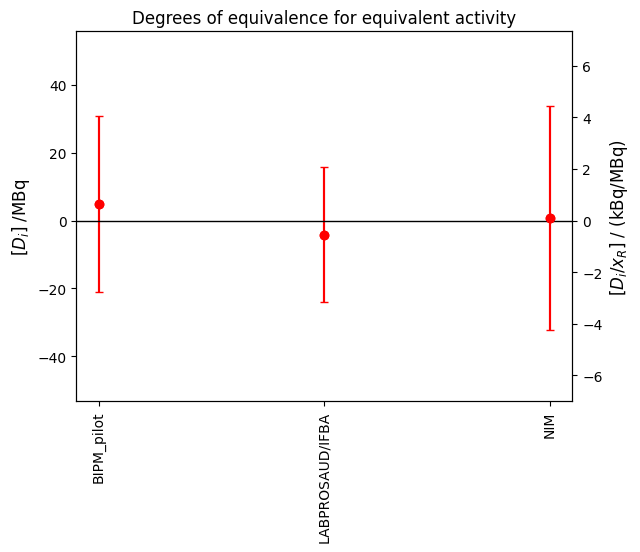

In [10]:
D=DoE(x,u,results[0],results[1],w=results[2].tolist())
for i in range(len(D[0])): print(f"{lab[i]}:\t D = {D[0][i]:.3g}  +/- {D[1][i]:.3g} (k=2)")
plotDoE(lab,D[0],D[1],D[2],D[3])

## Plot the PomPlot
Below the PomPlot is displayed from the above PMM analysis. It underlines the consistency of each point with the consensus value. It is related to $\zeta$ test implemented in PMM, see `if abs(e[i])>k*sqrt(u2e_incl[i]):` in PMM code where quantile `k` is relatated to the $\zeta$ lines in PomPlot? (to be check, it is indeed not clear...)

* L'autotest de PMM rejecte l'hypothèse nulle $H_0$ si $|d_i|>\zeta u(KCRV) \sqrt{1/w_i-1}$
* Le test de PomPlot rejecte l'hypothèse nulle $H_0$ si $|d_i|>\zeta 2\sqrt{(1-2w_i)u_i^2+u(KCRV)^2}$

Or Pommé montre dans son equation C.1 que $u(KCRV) \sqrt{1/w_i-1} = \sqrt{(1-2w_i)u_i^2+u(KCRV)^2}$

* L'autotest de PMM rejecte l'hypothèse nulle $H_0$ si $|d_i|>\zeta 2\sqrt{(1-2w_i)u_i^2+u(KCRV)^2}$
* Le test de PomPlot rejecte l'hypothèse nulle $H_0$ si $|d_i|>\zeta 2\sqrt{(1-2w_i)u_i^2+u(KCRV)^2}$


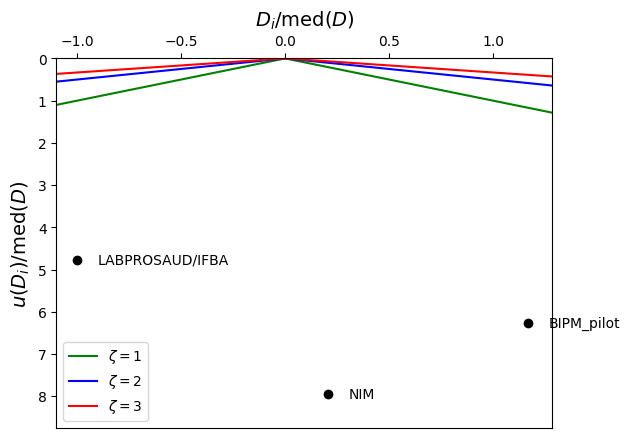

In [11]:
pomplot(lab,D[0],D[1])

## Re-Run PMM with the auto-test (can take time...)
Now the PMM is run with the auto-test to reject possible outliers

In [12]:
results=PMM(x,u,autoRej=True)
print(f"KCRV = {results[0]:.7g}")
print(f"u(KCRV) = {results[1]:.7g}")
print(f"weights = {results[2]}")
print(f"alpha = {results[3]:.7g}")
print(f"Birge ratio = {results[4]:.7g}")
print(f"dark uncertainty = {results[5]:.7g}")
if results[6] != []:
    for j in results[6]:
        print(f"detected outlier = {lab[j]}")
else: print(f"no outlier")

KCRV = 7599.149
u(KCRV) = 8.749053
weights = [0.31914894 0.42553191 0.25531915]
alpha = 1
Birge ratio = 0.3231052
dark uncertainty = 1e-06
no outlier


## Filtering the outliers 

In [13]:
lab = [item for idx, item in enumerate(lab) if idx not in results[6]]
x = [item for idx, item in enumerate(x) if idx not in results[6]]
u = [item for idx, item in enumerate(u) if idx not in results[6]]
print(f"Laboratory : {lab}")
print(f"x = {x}")
print(f"u = {u}")

Laboratory : ['BIPM_pilot', 'LABPROSAUD/IFBA', 'NIM']
x = [7604.0, 7595.0, 7600.0]
u = [16.0, 12.0, 20.0]


## Re-Re-Run PMM without the auto-test (can take time...)
Now the PMM is run again without the outliers

In [14]:
results=PMM(x,u,autoRej=False)
print(f"KCRV = {results[0]:.7g}")
print(f"u(KCRV) = {results[1]:.7g}")
print(f"weights = {results[2]}")
print(f"alpha = {results[3]:.7g}")
print(f"Birge ratio = {results[4]:.7g}")
print(f"dark uncertainty = {results[5]:.7g}")

KCRV = 7599.149
u(KCRV) = 8.749053
weights = [0.31914894 0.42553191 0.25531915]
alpha = 1
Birge ratio = 0.3231052
dark uncertainty = 1e-06


## Re-Plot the DoEs
Below the degrees of equivalences are plotted from above PMM KCRV.

BIPM_pilot:	 D = 4.85  +/- 26 (k=2)
LABPROSAUD/IFBA:	 D = -4.15  +/- 19.8 (k=2)
NIM:	 D = 0.851  +/- 33 (k=2)


<Figure size 800x600 with 0 Axes>

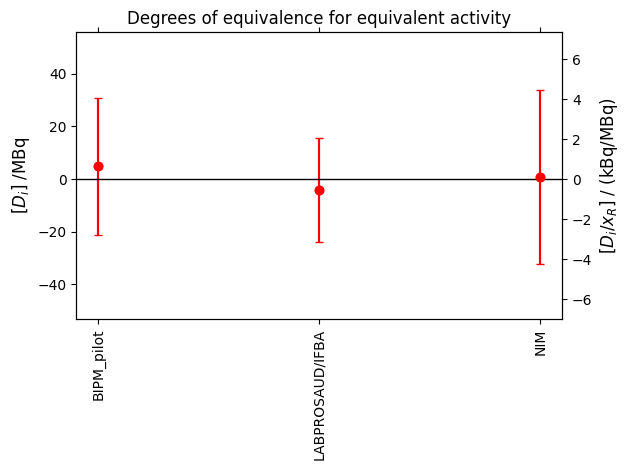

In [15]:
D=DoE(x,u,results[0],results[1],w=results[2].tolist())
for i in range(len(D[0])): print(f"{lab[i]}:\t D = {D[0][i]:.3g}  +/- {D[1][i]:.3g} (k=2)")
figure(figsize=(8, 6))
plotDoE(lab, D[0], D[1], D[2], D[3])
xticks(rotation=45)
tight_layout()
savefig("report/doe_plot.jpg", format="jpg", dpi=300)

In [ ]:
#Generate .txt file from KCRV and DoE
with open("report/rv_and_doe_summary.txt", "w") as f:
    # Header: KCRV and uncertainty
    f.write(f"KCRV = {results[0]:.7g}\n")
    f.write(f"u(KCRV) = {results[1]:.7g}\n\n")

    # DoE Table
    f.write("Degrees of Equivalence (k=2):\n")
    for i in range(len(D[0])):
        f.write(f"{lab[i]:<18} D = {D[0][i]:>6.3g}  +/- {D[1][i]:.2g}\n")


## Re-Plot the PomPlot
Below the PomPlot is displayed from the above PMM analysis. It underlines the consistency of each point with the consensus value. It is related to $\zeta$ test implemented in PMM, see `if abs(e[i])>k*sqrt(u2e_incl[i]):` in PMM code where quantile `k` is relatated to the $\zeta$ lines in PomPlot? (to be check, it is indeed not clear...)

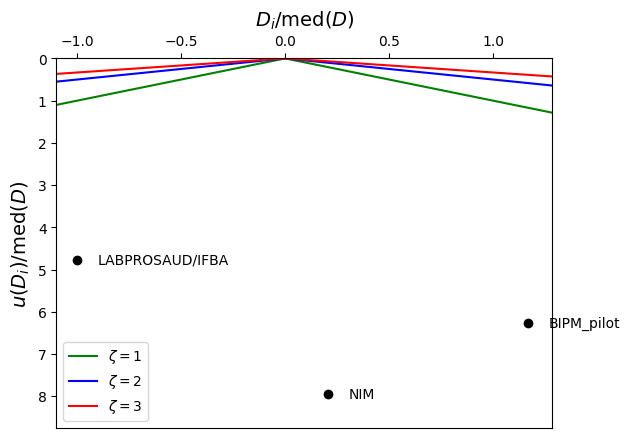

In [17]:
pomplot(lab,D[0],D[1])